

### <center>CSF372: Operating System </center>
### <center> Assignment 2 </center>
#### <center> Group 30 </center>


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [ ]:
def plot_threading(pro_number, file_name):
    data = pd.read_csv(file_name)
    data = data.to_numpy()

    X = data[:, 0]
    Y = data[:, 1]

    plt.figure(figsize=(9, 6))
    plt.plot(X, Y)
    plt.xlabel("No. of threads")
    plt.ylabel("Time (in nanoseconds)")
    plt.title(f"An analysis of no.of threads vs execution time for P{pro_number}")
    plt.show()

## **1. P1 - Reading Matrices**

The objective of P1 is to read lines from the input file using multithreading and analyze whether there is any correlation between the number of threads used and execution time.

The program is supposed to read two input files, each representing a matrix. Due to the nature of matrix multiplication, it is easier to transpose the second file, as both files were pre-processed to store the offset (in bytes) of the start of each line in memory (so that any line can be directly accessed by any thread using the fseek() function). If we don’t transpose the second file, the offset of each element will have to be stored (as a row will be multiplied by the corresponding columns of the second matrix). This will increase memory usage as compared to storing offsets of only the first line element. Also, row-by-row multiplication of elements (dot product) has much lesser chance of logical errors as compared to row-by-column multiplication and makes for more convenient debugging.

After pre-processing, we spawn a batch of threads, each reading a separate portion of the file. This kind of design avoids race conditions as no thread is accessing any common memory segments. The number of lines is divided by the number of threads, and each thread reads that particular portion of the file. 

The rows are each read into a shared memory segment from which P2 can also read and do the actual computation, however synchronization is ensured through the usage of flags (described in the P2 section).

Analysis: On varying the number of threads, we found that intially, as the number of threads increased, the execution time decreased. However, after reaching a particular no.of threads that ensure minimum execution time, increasing the number of threads further did not decrease the execution time, but increased it instead. We concluded that this is because after reaching an optimal point, the overhead of creating new threads and context switches outweighs the speedup caused by them, thus steadily increasing the time.


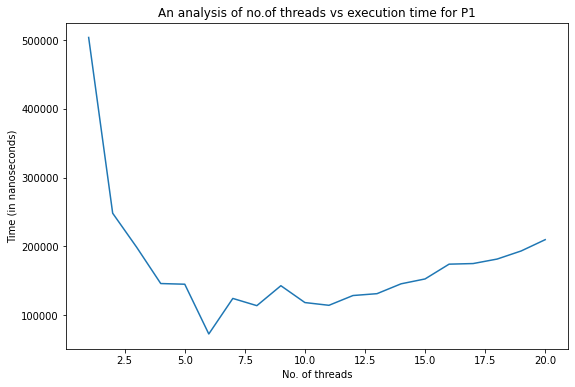

In [ ]:
plot_threading(1, 'P1_data_20.csv')

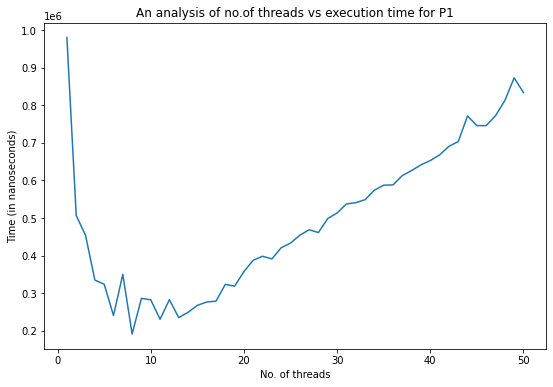

In [ ]:
plot_threading(1, 'P1_data_50.csv')

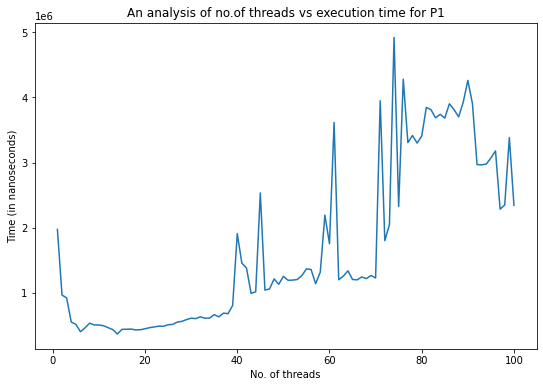

In [ ]:
plot_threading(1, 'P1_data_100.csv')

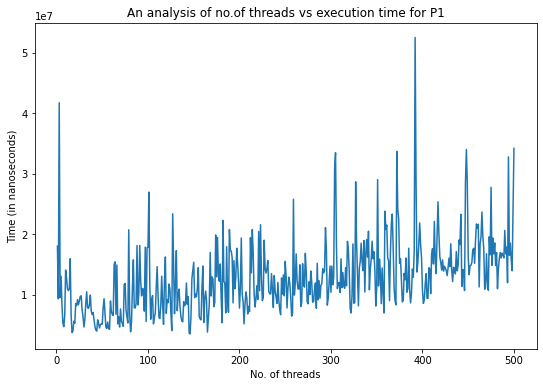

In [ ]:
plot_threading(1, 'P1_data_500.csv')

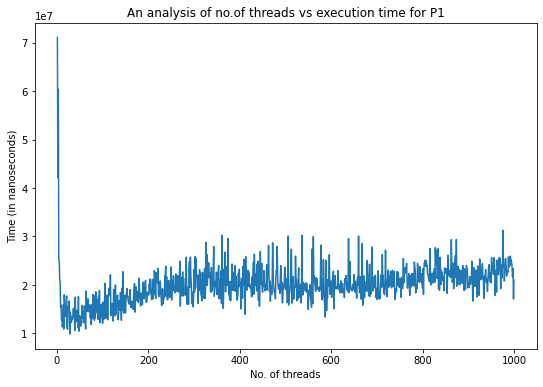

In [ ]:
plot_threading(1, 'P1_data_1000.csv')

## **2. P2 - Multiplying Matrices**


For P2, the objective is to receive the data read by P1 through IPC and compute the final product using multithreading. We are to analyze whether there is any correlation between the number of threads used and execution time.

For thread allocation, we use a similar algorithm as P1: the total number of cells is divided by the number of threads, and each thread is allotted a specific sequence of contiguous cells to compute the product. Again, this ensures there are no race conditions between any two threads, as they all work with different memory segments. There is a matrix to check whether each cell has been written to by P1; if this flag is marked true, then P2's thread will read from it and compute the product; otherwise, it will keep attempting to read until the cell has been finally written to. This ensures that P2 doesn't attempt to read from any cell that hasn't been written to by P1 and uses garbage values from computation (essentially to ensure shared memory synchronization).

Once all the threads exit and join, the output matrix is written to a text file. As file IO operations are computationally expensive, doing it once at the end is better than writing repeatedly. 

Analysis: For smaller cases, the effect of system processors and context switches is amplified due to very small execution time, whereas for larger cases the same observations were reported as P1; that is, parallelization decreases execution time till a certain minimum, following which it again starts to increase. This is because of a limited number of CPU cores, which limits the parallelism that can be achieved.

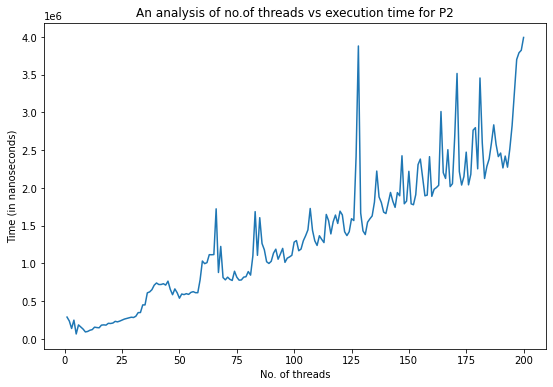

In [ ]:
plot_threading(2, 'P2_data_20.csv')

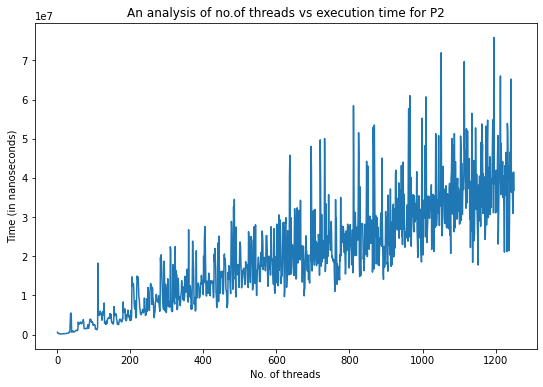

In [ ]:
plot_threading(2, 'P2_data_50.csv')

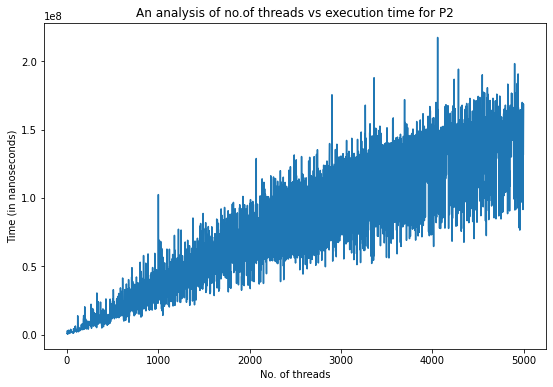

In [ ]:
plot_threading(2, 'P2_data_100.csv')

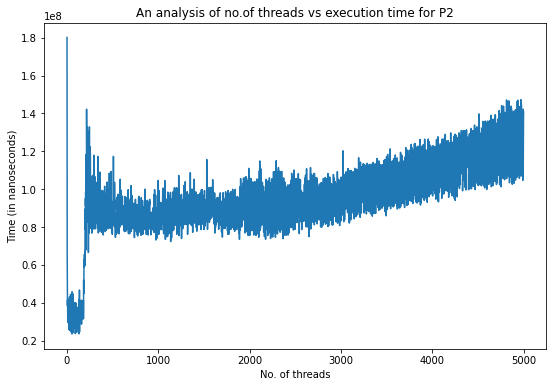

In [ ]:
plot_threading(2, 'P2_data_500.csv')

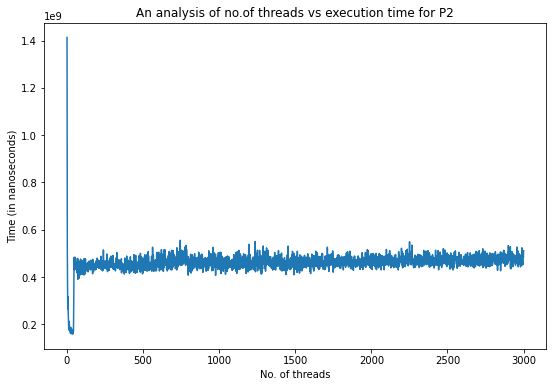

In [ ]:
plot_threading(2, 'P2_data_1000.csv')

## **3. P3 - Scheduler**

P3 forks and execs the child processes P1 and P2, but just before calling the exec, the processes are paused using a kill signal (SIGSTP), and a resume signal (SIGCONT) is sent to the processes when the scheduler schedules them. We are using signals to simulate the Round Robin Algorithm for a given Quanta.

As there are only two processes to schedule, a variable is used to denote the current active process. The value of that variable is flipped in each iteration between 0 and 1. If the current process is already done but the other is not, it flips again.
The current process is then continued using kill command with appropriate flags (SIGCONT) and the scheduler sleeps for time specified by quantum and then suspends the current process.
This routine is repeated until both processes are done.
The time delay between the scheduler suspending the current process, resuming the process that needs to be scheduled and the latency of processes receiving signals from the scheduler results in the context switch overhead.

For our analysis we have plotted the turnaround time, waiting time for both P1 and P2 against logarithm of workload for the given quantas of 1ms and 2ms. (where our workload is defined as $N\times M\times K$ where $N \times M$ is the size of matrix 1 and $M \times K$ is the size of matrix 2).  

We have benchmarked on similar workloads multiple times to study the variance on execution time due to system processes.


In [ ]:
def plot_scheduler(pro_number, file_name, quanta, wait_turnaround_time):
    data = pd.read_csv(file_name)
    data.sort_values(by=['Workload size'])
    data = data.to_numpy()

    from math import log10
    X = list()
    for i in data[:, 0]:
        X.append(log10(i))

    X = np.array(X)
    Y = data[:, pro_number]

    plt.figure(figsize=(10, 6))
    plt.scatter(X, Y)
    plt.xlabel("$log_{10}(Workload size)$")
    plt.ylabel(wait_turnaround_time)
    plt.title(f"{wait_turnaround_time} vs $log_{{10}}(Workload size)$ for P{pro_number} for Quanta {quanta} ms")
    plt.show()


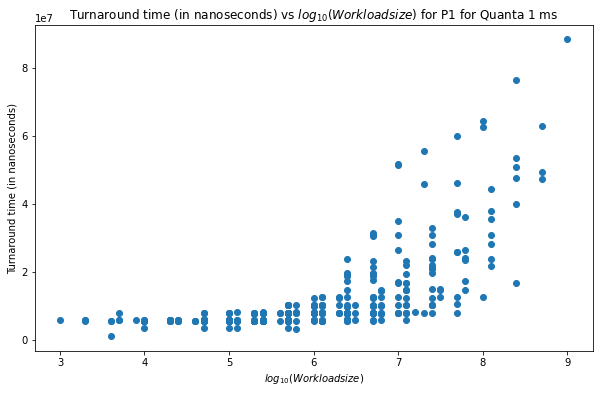

In [ ]:
plot_scheduler(1, 'turnaround_1.csv', 1, 'Turnaround time (in nanoseconds)')

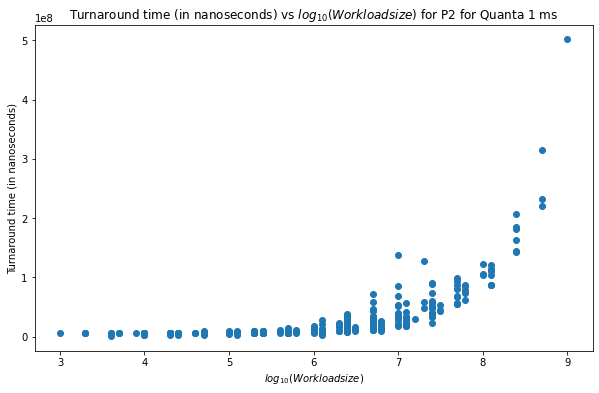

In [ ]:
plot_scheduler(2, 'turnaround_1.csv', 1, 'Turnaround time (in nanoseconds)')

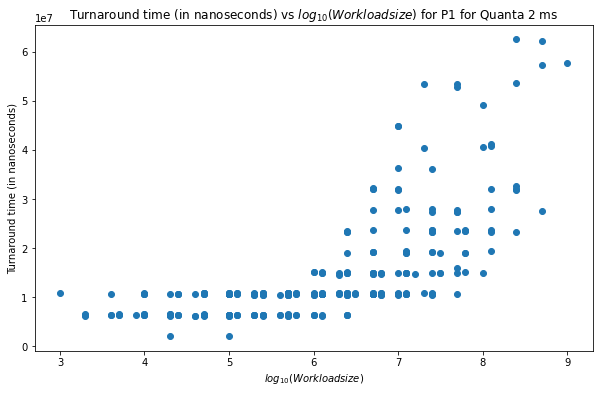

In [ ]:
plot_scheduler(1, 'turnaround_2.csv', 2, 'Turnaround time (in nanoseconds)')


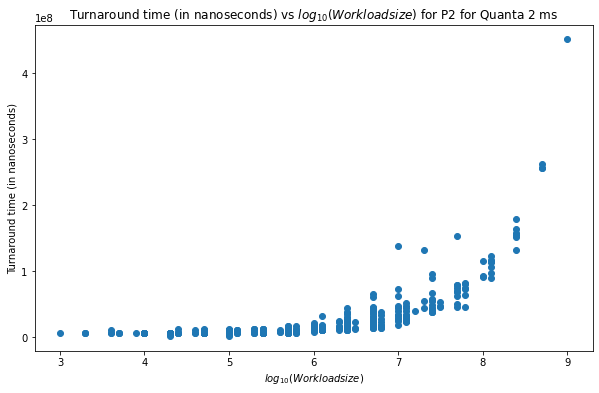

In [ ]:
plot_scheduler(2, 'turnaround_2.csv', 2, 'Turnaround time (in nanoseconds)')


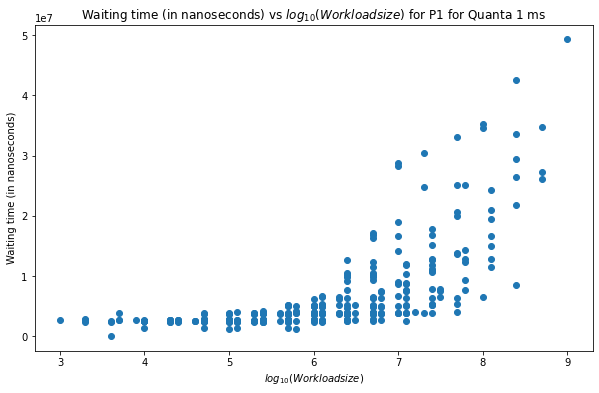

In [ ]:
plot_scheduler(1, 'wait_1.csv', 1, 'Waiting time (in nanoseconds)')

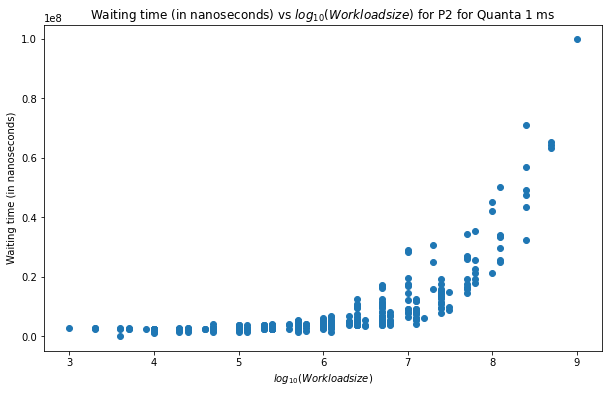

In [ ]:
plot_scheduler(2, 'wait_1.csv', 1, 'Waiting time (in nanoseconds)')

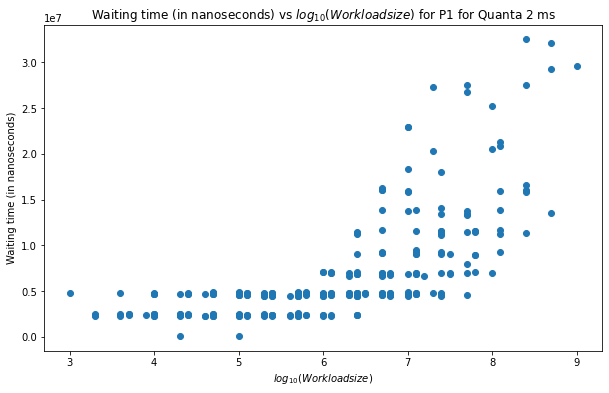

In [ ]:
plot_scheduler(1, 'wait_2.csv', 2, 'Waiting time (in nanoseconds)')

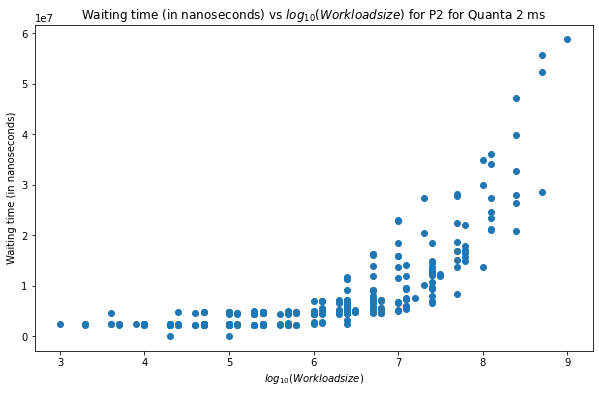

In [ ]:
plot_scheduler(2, 'wait_2.csv', 2, 'Waiting time (in nanoseconds)')

### Quanta 1 : Tabulated Summary

In [ ]:
quanta_1_data = pd.read_csv("quanta_1.csv")
quanta_1_data

,Workload size,Turnaround time P1,Turnaround time P2,Waiting time P1,Waiting time P2,Context switch time
0,1000,5744135,6719187,2744135,2719187,12765033
1,2000,5880594,6885965,2880594,2885965,2484335
2,5000,7793208,5515437,3793208,2515437,1281950
3,10000,5639351,6565894,2639351,2565894,182760
4,25000,5715736,6630138,2715736,2630138,2799483
...,...,...,...,...,...,...
338,50000000,60001456,80413045,33001456,34413045,103593880
339,100000000,62548470,104937027,34548470,44937027,110341786
340,250000000,76462397,182074315,42462397,71074315,127717476
341,500000000,49332335,221213367,27332335,65213367,260624400


### Quanta 2 : Tabulated Summary

In [ ]:
quanta_2_data = pd.read_csv("quanta_2.csv")
quanta_2_data

,Workload size,Turnaround time P1,Turnaround time P2,Waiting time P1,Waiting time P2,Context switch time
0,1000,10746578,6338186,4746578,2338186,338205
1,2000,6250769,6235229,2250769,2235229,185544
2,5000,6454072,6416910,2454072,2416910,171348
3,10000,10724101,6482478,4724101,2482478,4707191
4,25000,10683351,6369741,4683351,2369741,4947313
...,...,...,...,...,...,...
338,50000000,52781939,79846438,26781939,27846438,128770162
339,100000000,49221071,92987487,25221071,34987487,85974247
340,250000000,53529097,151879088,27529097,39879088,122395858
341,500000000,57298219,262424703,29298219,52424703,131732587


### <ins> Analysis of Round Robin with different Quantas </ins>
We observe that time wasted due to context switches (latency due to signals) reduces considerably when the quanta is longer, that is context switch with quanta as 2ms is lower than the one with 1ms. The total waiting time and the turnaround time increases with increasing quanta (for higher load, the results might be skewed to due to system processes and limitations of our CPU).